# Training Predictive Model

### Import libraries

In [1]:
import datetime, json, random, IPython, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torch, pytorch_lightning as pl
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger

# ⚡ NEW: modern API
from models import GazeDataModule, SingleModel, EyesModel, FullModel
from utils  import (
    get_config,
    tune_asha,
    get_best_results,
    save_model,
    plot_asha_param_grid,
    plot_parallel_param_loss,
    latest_tune_dir,
    _build_datamodule,
    _build_model,
    predict_screen_errors,
)

# project settings
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload
%autoreload 2

### Dataset information

In [2]:
df = pd.read_csv("data/positions.csv")
region_map = np.load("data/region_map.npy").T

print(f"# of samples: {len(df)}")
coverage = np.count_nonzero(region_map > 0) / region_map.size * 100
print(f"Coverage: {coverage:.2f}% of screen surface")
print(f"Crop size: {SETTINGS['image_size']} x {SETTINGS['image_size']} px")

# of samples: 20077
Coverage: 61.84% of screen surface
Crop size: 64 x 64 px


In [3]:
search_space = {
    "seed":  tune.randint(0, 10000),
    "bs":    tune.choice([256, 512, 1024]),
    "lr":    tune.loguniform(1e-4, 3e-3),
    "channels": tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "hidden":   tune.choice([128, 256, 512]),
}

analysis = tune_asha(
    search_space   = search_space,
    train_func     = "single",  # utils infers correct trainer wrapper
    name           = "face_aligned/tune",
    img_types      = ["face_aligned"],
    num_samples    = 20,
    num_epochs     = 15,
    data_dir     = Path.cwd() / "data",
    seed           = 87,
)

2025-05-15 14:13:33,204	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-15 14:13:37,067	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-05-15 14:13:37,071	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_tune_wrapper pid=31488) Seed set to 9532
(_tune_wrapper pid=31488) Using bfloat16 Automatic Mixed Precision (AMP)
(_tune_wrapper pid=31488) GPU available: True (cuda), used: True
(_tune_wrapper pid=31488) TPU available: False, using: 0 TPU cores
(_tune_wrapper pid=31488) HPU available: False, using: 0 HPUs
(_tune_wrapper pid=31488) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_tune_wrapper pid=31488) 
(_tune_wrapper pid=31488)   | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
(_tune_wrapper pid=31488) ------------------------------------------------------------------------------------------
(_tune_wrapper pid=31488) 0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
(_tune_wrapper pid=31488) 1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
(_tune_wrapper pid=31488) 2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
(_tune_wrapper pid=31488) 3 | rmse

Trial name,checkpoint_dir_name,date,done,hostname,iterations_since_restore,loss,mae,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
_tune_wrapper_07906_00000,checkpoint_000014,2025-05-15_14-26-27,True,DESKTOP-B40NR52,15,204.871,205.371,127.0.0.1,31488,True,760.339,42.7435,760.339,1747311987,15,07906_00000
_tune_wrapper_07906_00001,checkpoint_000007,2025-05-15_14-35-20,True,DESKTOP-B40NR52,8,381.159,381.659,127.0.0.1,26508,True,521.435,52.0344,521.435,1747312520,8,07906_00001
_tune_wrapper_07906_00002,checkpoint_000000,2025-05-15_14-38-03,True,DESKTOP-B40NR52,1,738.238,738.737,127.0.0.1,3160,True,152.368,152.368,152.368,1747312683,1,07906_00002
_tune_wrapper_07906_00003,checkpoint_000014,2025-05-15_14-57-39,True,DESKTOP-B40NR52,15,190.841,191.341,127.0.0.1,24172,True,1162.63,70.2115,1162.63,1747313859,15,07906_00003
_tune_wrapper_07906_00004,checkpoint_000000,2025-05-15_15-00-36,True,DESKTOP-B40NR52,1,756.002,756.502,127.0.0.1,28976,True,163.724,163.724,163.724,1747314036,1,07906_00004
_tune_wrapper_07906_00005,checkpoint_000000,2025-05-15_15-04-07,True,DESKTOP-B40NR52,1,740.518,741.018,127.0.0.1,3416,True,199.623,199.623,199.623,1747314247,1,07906_00005
_tune_wrapper_07906_00006,checkpoint_000000,2025-05-15_15-07-22,True,DESKTOP-B40NR52,1,741.5,742,127.0.0.1,2660,True,180.282,180.282,180.282,1747314442,1,07906_00006
_tune_wrapper_07906_00007,checkpoint_000000,2025-05-15_15-10-05,True,DESKTOP-B40NR52,1,750.876,751.376,127.0.0.1,27000,True,151.627,151.627,151.627,1747314605,1,07906_00007
_tune_wrapper_07906_00008,checkpoint_000000,2025-05-15_15-13-01,True,DESKTOP-B40NR52,1,755.745,756.245,127.0.0.1,31344,True,166.022,166.022,166.022,1747314781,1,07906_00008
_tune_wrapper_07906_00009,checkpoint_000001,2025-05-15_15-16-55,True,DESKTOP-B40NR52,2,698.119,698.619,127.0.0.1,16832,True,222.564,56.825,222.564,1747315015,2,07906_00009


(_tune_wrapper pid=31488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face_aligned/tune_20250515-141328/07906_00000/checkpoint_000000)
(_tune_wrapper pid=31488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face_aligned/tune_20250515-141328/07906_00000/checkpoint_000001)
(_tune_wrapper pid=31488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face_aligned/tune_20250515-141328/07906_00000/checkpoint_000002)
(_tune_wrapper pid=31488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face_aligned/tune_20250515-141328/07906_00000/checkpoint_000003)
(_tune_wrapper pid=31488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Des

Best hyperparameters:  {'seed': 4345, 'bs': 512, 'lr': 0.0019393593451826068, 'channels': (64, 128, 256), 'hidden': 512}


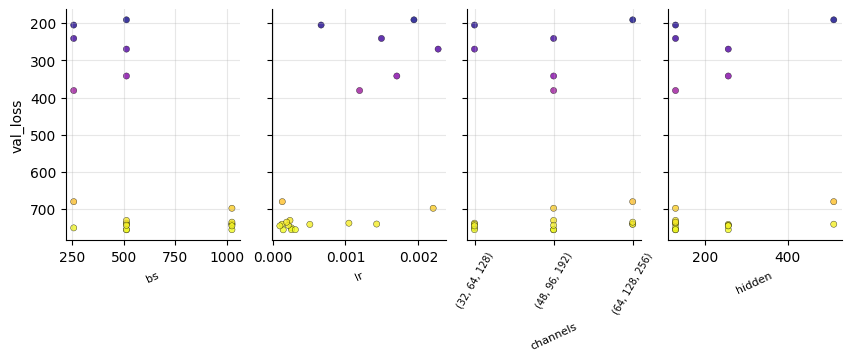

WindowsPath('media/images/1_face_aligned_explore_scatter.png')

In [4]:
plot_asha_param_grid(analysis, save_path="media/images/1_face_aligned_explore_scatter.png")

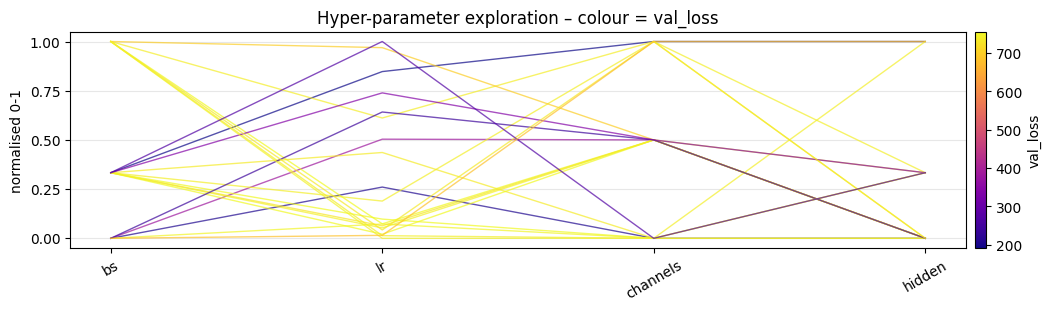

WindowsPath('media/images/1_face_aligned_explore_parallel.png')

In [5]:
plot_parallel_param_loss(analysis, save_path="media/images/1_face_aligned_explore_parallel.png")

In [6]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

tune_dir = Path.cwd() / "logs" / "face_aligned"
best_cfg = get_best_results(latest_tune_dir(tune_dir))
pl.seed_everything(best_cfg["seed"])

dm = GazeDataModule(
    data_dir = Path.cwd() / "data",
    batch_size = best_cfg["bs"],
    img_types = ["face_aligned"],
    seed = best_cfg["seed"],
)

model = _build_model(best_cfg, ["face_aligned"])

trainer = pl.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices = "auto",
    precision = "bf16-mixed",           # or "16-mixed" if your GPU supports it
    logger = TensorBoardLogger(
        save_dir = Path.cwd() / "logs",
        name     = f"face_aligned/final/{start_time}",
        log_graph = True,
    ),
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename = "best",
            monitor  = "val_loss",
            mode     = "min",
            save_last = True,
            save_top_k = 1,
        )
    ],
)

trainer.fit(model, datamodule=dm)
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)  # ←
model.load_state_dict(state["state_dict"])

# save weights + config next to lightning checkpoint
out_dir = Path.cwd() / "logs" / "face_aligned" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),                   # save on CPU to shrink file size
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

Seed set to 4345
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Best of 'c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face_aligned\tune_20250515-141328' ---

Directory: 07906_00003
Loss: 190.84
Pixel error: 13.81
Hyperparameters...
- seed: 4345
- bs: 512
- lr: 0.0019393593451826068
- channels: [64, 128, 256]
- hidden: 512


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------------------------
0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
3 | rmse      | MeanSquaredError  | 0      | train | ?              | ?             
4 | backbone  | ConvStack         | 371 K  | train | [1, 3, 64, 64] | [1, 256, 1, 1]
5 | regressor | Sequential        | 132 K  | train | [1, 256, 1, 1] | [1, 2]        
------------------------------------------------------------------------------------------
503 K     Trainable params
0         Non-trainable params
503 K     Total params
2.015     Total estimated model params size (MB)
26        Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
test_results = trainer.test(ckpt_path="best", datamodule=dm)[0]

loss = test_results["test_loss_epoch"]
mae  = test_results["test_mae_epoch"]

mse  = test_results.get("test_mse_epoch",  test_results.get("test_mse"))
rmse = test_results.get("test_rmse_epoch", test_results.get("test_rmse"))

print("────────  Test set  ────────")
print(f"MSE   : {mse:8.2f}  px²")
print(f"RMSE  : {rmse:8.2f}  px")
print(f"MAE   : {mae:8.2f}  px")
print(f"Loss  : {loss:8.2f}  (Smooth-L1)")

Restoring states from the checkpoint path at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face_aligned/final/2025-May-15 16-13-52\version_0\checkpoints\best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face_aligned/final/2025-May-15 16-13-52\version_0\checkpoints\best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         39.58333206176758
     test_mae_epoch         40.080177307128906
        test_mse               3552.7734375
        test_rmse            59.18300247192383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────  Test set  ────────
MSE   :  3552.77  px²
RMSE  :    59.18  px
MAE   :    40.08  px
Loss  :    39.58  (Smooth-L1)


  0%|          | 0/20077 [00:00<?, ?it/s]

Average error: 59.16px over 2008 samples


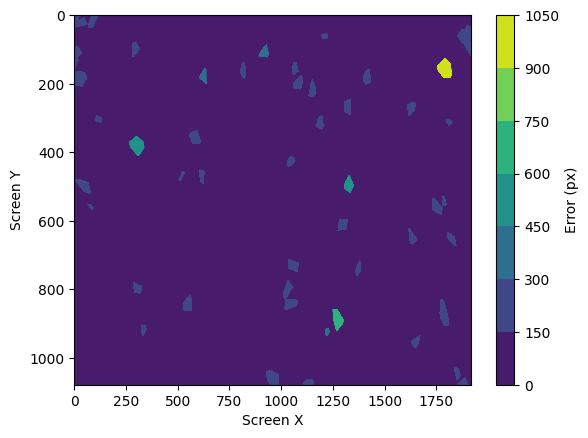

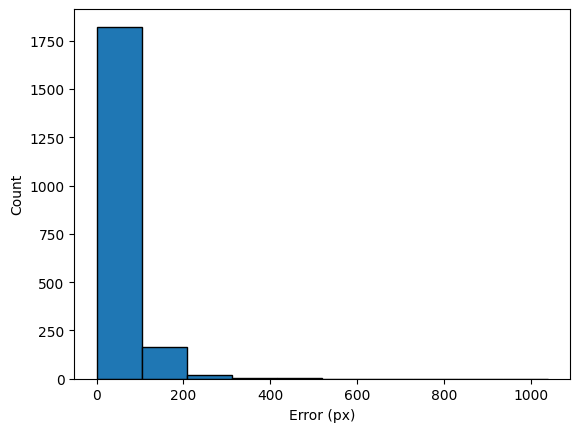

In [8]:
predict_screen_errors(
    "face_aligned",
    path_model  = out_dir/"eyetracking_model.pt",
    path_config = out_dir/"eyetracking_config.json",
    path_plot   = out_dir/"error_heatmap_face_aligned.png",
    path_errors = out_dir/"errors.npy",
    steps       = 10,
)